# **Import all the Libraries**

In [1]:
## import commands of different important libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
## supress future warning
tf.get_logger().setLevel('ERROR')

#import command of model  resnet50 model
from tensorflow.keras.applications import ResNet50

# import command for sequential layer
from tensorflow.python.keras.models import Sequential

# dense,flaten and pooling layers
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D


# **Set all the Constants**

In [2]:
## setting model parameters
BATCH_SIZE =32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import data into tensorflow dataset object**

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [4]:
# loading train dataset 
train_df= tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5144 files belonging to 3 classes.


In [5]:
# loading test dataset
test_df=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data/test",
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1288 files belonging to 3 classes.


This above code is using TensorFlow's image_dataset_from_directory method to load the test dataset from a directory. Here's a breakdown of the parameters:

/content/drive/MyDrive/Data/test: This is the path to the directory containing the test dataset.

**seed=123:** This sets a random seed for shuffling the dataset.

**shuffle=True**: This tells the method to shuffle the dataset before loading it.

**image_size=(IMAGE_SIZE, IMAGE_SIZE):** This sets the desired size of the images in the dataset. IMAGE_SIZE is a variable that should be defined earlier in the code.

**batch_size=BATCH_SIZE:** This sets the size of the batches to be used during training. BATCH_SIZE is another variable that should be defined earlier in the code.

After running this code, test_df will be a tf.data.Dataset object containing the test images and their corresponding labels. This can then be used for evaluating the model's performance on the test set.

In [6]:
## check that how much classes are there in dataset 
class_names = train_df.class_names
class_names

['COVID19', 'NORMAL', 'PNEUMONIA']

In [7]:
## showing one batch from the dataset and getting there labels also.
for image_batch, labels_batch in train_df.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 0 0 0 2 2 2 1 1 2 1 1 1 2 2 2 0 0 2 2 1 2 2 2 2 1 0 2 2 2 2]


# **Visualize some of the images from our dataset**

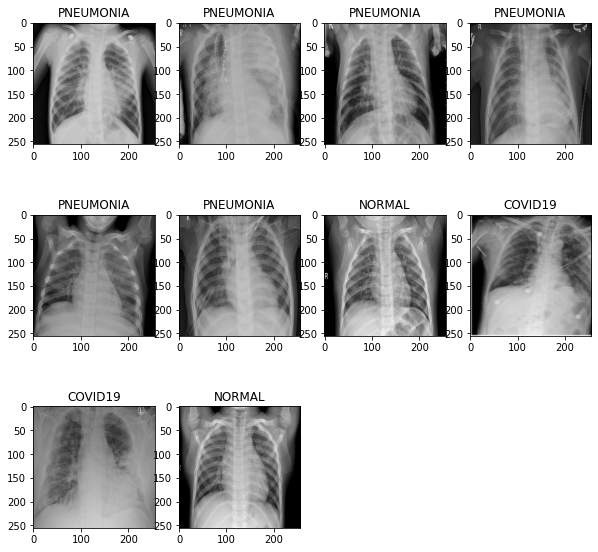

In [8]:
## showing the images of one batch of our training data
plt.figure(figsize=(10, 10))
for image_batch,label_batch in train_df.take(1):
  for i in range(10):
    ax = plt.subplot(3,4, i + 1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])

# **Function to Split Dataset**

In [9]:
def get_data_partition(ds,training_size=0.7,val_size=0.3):
  # taking length of dataset
  len_ds=len(ds)

  # taking length of partition
  training=int(len_ds*training_size)
  val=int(len_ds*val_size)
   ## Taking values of partition
  train_ds=ds.take(training)
  val_ds=ds.skip(training).take(val)

  return train_ds,val_ds

In [10]:
train_ds, val_ds= get_data_partition(train_df)

# **Building the Model**

# **Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# **Data Augmentation**

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [12]:
# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    
    #resizing the images 
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    # rescaling the images
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    
    # Randomly rotate the image
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    # Randomly flip the image horizontally and vertically
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    # Randomly adjust the contrast of the image
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    # Randomly translate the image horizontally and vertically
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

# Apply the data augmentation pipeline to the train_ds
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [13]:
# Apply the resizing and rescaling on test val_ds
val_ds = val_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
)

# **ResNet50 Model Architecture**

In [14]:
# code for  creating a base model for transfer learning using the ResNet50 architecture
base_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), include_top=False, weights="imagenet")

94765736/94765736 [==============================] - 1s 0us/step


In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics = ['acc'])

In [17]:

history = model.fit(train_ds, validation_data = val_ds,
                      batch_size=64,
                      epochs =10)

Epoch 1/10
112/112 [==============================] - 440s 4s/step - loss: 1.3383 - acc: 0.6339 - val_loss: 0.8081 - val_acc: 0.6719
Epoch 2/10
112/112 [==============================] - 162s 1s/step - loss: 0.8279 - acc: 0.6616 - val_loss: 0.7616 - val_acc: 0.6777
Epoch 3/10
112/112 [==============================] - 163s 1s/step - loss: 0.7987 - acc: 0.6571 - val_loss: 0.7406 - val_acc: 0.6699
Epoch 4/10
112/112 [==============================] - 162s 1s/step - loss: 0.7698 - acc: 0.6655 - val_loss: 0.7057 - val_acc: 0.6706
Epoch 5/10
112/112 [==============================] - 161s 1s/step - loss: 0.7327 - acc: 0.6922 - val_loss: 0.6717 - val_acc: 0.7083
Epoch 6/10
112/112 [==============================] - 125s 1s/step - loss: 0.7116 - acc: 0.7023 - val_loss: 0.6524 - val_acc: 0.6855
Epoch 7/10
112/112 [==============================] - 162s 1s/step - loss: 0.6889 - acc: 0.7048 - val_loss: 0.6283 - val_acc: 0.7240
Epoch 8/10
112/112 [==============================] - 160s 1s/step - 

# **Densenet121 architecture**

In [18]:
## import command of DenseNet121
from tensorflow.keras.applications import DenseNet121

# code for  creating a base model for transfer learning using the DenseNet121 architecture
base_model = DenseNet121(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), include_top=False, weights="imagenet")

29084464/29084464 [==============================] - 1s 0us/step


In [19]:
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(3, activation='softmax')(x)

dense_model = tf.keras.models.Model(base_model.input, x)


## compile the model
dense_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = dense_model.fit(train_ds, validation_data = val_ds,
                      batch_size=32,
                      epochs =10)

Epoch 1/10
112/112 [==============================] - 138s 1s/step - loss: 0.8433 - accuracy: 0.8103 - val_loss: 0.4583 - val_accuracy: 0.8177
Epoch 2/10
112/112 [==============================] - 161s 1s/step - loss: 0.2657 - accuracy: 0.9074 - val_loss: 0.7583 - val_accuracy: 0.7331
Epoch 3/10
112/112 [==============================] - 161s 1s/step - loss: 0.2310 - accuracy: 0.9216 - val_loss: 0.5019 - val_accuracy: 0.8288
Epoch 4/10
112/112 [==============================] - 162s 1s/step - loss: 0.2072 - accuracy: 0.9252 - val_loss: 0.6480 - val_accuracy: 0.7780
Epoch 5/10
112/112 [==============================] - 129s 1s/step - loss: 0.1950 - accuracy: 0.9358 - val_loss: 0.3566 - val_accuracy: 0.8646
Epoch 6/10
112/112 [==============================] - 162s 1s/step - loss: 0.1685 - accuracy: 0.9403 - val_loss: 0.8297 - val_accuracy: 0.7572
Epoch 7/10
112/112 [==============================] - 127s 1s/step - loss: 0.1688 - accuracy: 0.9403 - val_loss: 0.5134 - val_accuracy: 0.8392

# **Run prediction on a sample image**

first image to predict
actual label: PNEUMONIA
1/1 [==============================] - 2s 2s/step
predicted label: PNEUMONIA


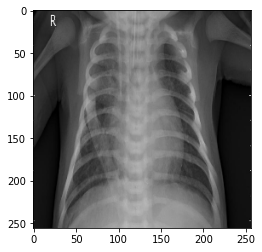

In [21]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):
    
    first_image = images_batch[0].numpy()
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = dense_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# **Write a function for inference**

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = dense_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# **Now run inference on few sample images**

1/1 [==============================] - 0s 33ms/step


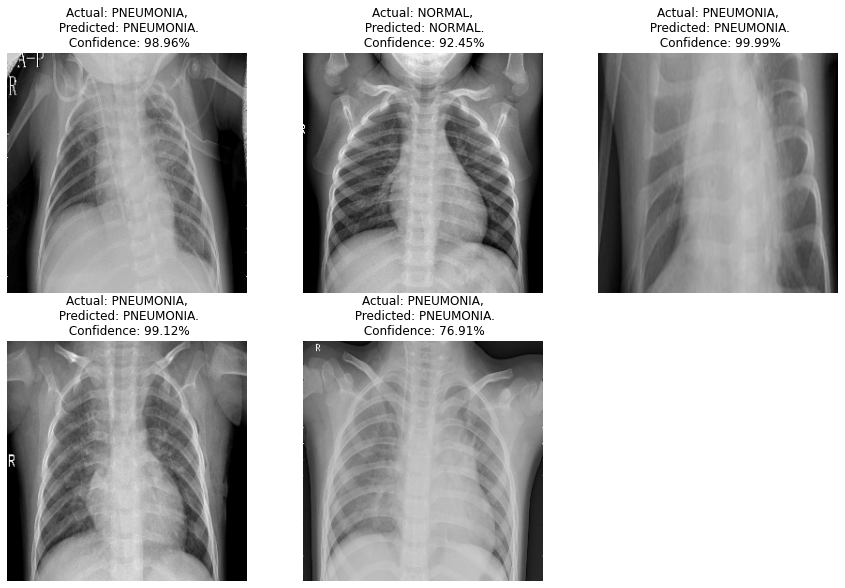

In [23]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        
        predicted_class, confidence = predict(base_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")